In [1]:
import numpy as np
from scipy.stats import percentileofscore
import pandas as pd

# 原始 dataset 數值

data = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/experiment_index.csv')

original_values = data['yield'].values

std_o = (original_values).std()  # 計算標準差
mean_o = (original_values).mean()


print(original_values)

# 假設有 3 個 dataset 的最佳解數值

methods = ['ABC','PSO','Random']
rounds = ['round1', 'round2', 'round3', 'round4', 'round5', 'round6','round7','round8','round9','round10']

bestnn = {}

for method in methods:
    best = {}
    for roundn in rounds:
        # 讀取 CSV
        df = pd.read_csv(f'/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/{roundn}/cycle5.csv')  # 替換成你的檔案路徑

        # 檢查欄位
        if 'yield' not in df.columns:
            raise ValueError("欄位 'crystal_size' 不存在於 CSV 中")

        # 分組
        group_size = 10
        groups = [df['yield'][i:i+group_size].values for i in range(0, len(df), group_size)]
        group_max = [max(g) for g in groups]
        cumulative_max = [max(group_max[:i+1]) for i in range(len(group_max))]
        best[roundn] = cumulative_max
        
    bestnn[method] = best    
    # 將所有 list 轉成 numpy array
    all_lists = np.array(list(best.values()))  # shape: (5, n)

dict1 = bestnn['ABC']
dict2 = bestnn['PSO']
dict3 = bestnn['Random']

best_solutions = {}
best_solutions['ABC'] = np.array([v[-1] for v in dict1.values()])
best_solutions['PSO'] =  np.array([v[-1] for v in dict2.values()])
best_solutions['Random'] = np.array([v[-1] for v in dict3.values()])

# 計算每個最佳解的 percentile rank
for method in methods:
    pr_list = [percentileofscore(original_values, val, kind='rank') for val in best_solutions[method]]
    Z = (np.mean(best_solutions[method])-mean_o)/std_o  # 計算平均最佳解
    # 計算平均 PR
    avg_pr = np.mean(pr_list)

    print("method:%s\n10 rounds best solutions PR:\n"%(method), pr_list)
    print("mean PR:", avg_pr)
    print("mean Z-score:", Z)
    print("--------------------------------------------------")


[ 5.47  0.   78.95 ...  0.78  1.8   1.06]
method:ABC
10 rounds best solutions PR:
 [87.44959677419355, 97.12701612903226, 92.89314516129032, 83.06451612903226, 88.60887096774194, 92.74193548387096, 93.59879032258064, 98.38709677419355, 96.01814516129032, 96.16935483870968]
mean PR: 92.60584677419354
mean Z-score: 2.0514394049546767
--------------------------------------------------
method:PSO
10 rounds best solutions PR:
 [92.59072580645162, 96.5725806451613, 90.82661290322581, 92.59072580645162, 90.27217741935483, 97.47983870967742, 93.8508064516129, 98.38709677419355, 94.20362903225806, 93.29637096774194]
mean PR: 94.0070564516129
mean Z-score: 2.198811877744052
--------------------------------------------------
method:Random
10 rounds best solutions PR:
 [88.55846774193549, 90.12096774193549, 88.91129032258064, 90.82661290322581, 92.94354838709677, 84.77822580645162, 90.27217741935483, 91.93548387096774, 91.43145161290323, 90.9274193548387]
mean PR: 90.07056451612904
mean Z-score: 1

In [2]:
import pandas as pd
import numpy as np

methods = ['ABC', 'PSO', 'Random']
rounds = ['round1', 'round2', 'round3', 'round4', 'round5', 'round6', 'round7', 'round8', 'round9', 'round10']

bestnn = {}
best_smiles = {}

for method in methods:
    best = {}
    best_smi = {}
    
    for roundn in rounds:
        # 讀取 CSV
        df = pd.read_csv(
            f'/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/{roundn}/cycle5.csv'
        )
        
        if 'yield' not in df.columns or 'Ligand_SMILES' not in df.columns:
            raise ValueError("Yield 中必須同時包含 'crystal_size' 和 'SMILES' 欄位")

        # 分組
        group_size = 10
        groups = [df.iloc[i:i+group_size] for i in range(0, len(df), group_size)]
        
        # 每組的最佳 crystal_size 與對應 SMILES
        group_best_rows = [g.loc[g['yield'].idxmax()] for g in groups]
        
        # 累積最大值（best so far）
        cumulative_best_rows = []
        current_best = None
        for row in group_best_rows:
            if current_best is None or row['yield'] > current_best['yield']:
                current_best = row
            cumulative_best_rows.append(current_best)
        
        # 存 crystal_size
        best[roundn] = [r['yield'] for r in cumulative_best_rows]
        # 存 SMILES
        best_smi[roundn] = [r['Ligand_SMILES'] for r in cumulative_best_rows]
    
    bestnn[method] = best
    best_smiles[method] = best_smi

# 範例：印出 ABC 的 round1 前幾 cycle 的最佳 SMILES

top_smiles_each_round = {m: {r: best_smiles[m][r][-1] for r in rounds} for m in methods}

for method in methods:
    print(f"Best SMILES for {method} in each round:")
    for roundn, smiles in top_smiles_each_round[method].items():
        print(f"{smiles}")
#print(top_smiles_each_round)


Best SMILES for ABC in each round:
Cc1ccc(-c2ccc(CP(C(C)C)C(C)C)cc2)c(C)c1
CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1
CN(C)c1ccccc1-c1ccccc1P(c1ccccc1N(C)C)C(C)(C)C
c1ccc(PC2=NC(P(c3ccccc3)c3ccccc3)C(c3ccccc3)N2)cc1
C#CCN(C(=O)c1c2ccccc2nc2onc(C)c12)P(c1ccccc1)C1CCCCC1
CC(C)c1cc(C(C)C)c(CP(c2ccccc2)C2CCCCC2)c(C(C)C)c1
CC(C)c1cc(C(C)C)c(P(Cc2ccccc2)C2CCCCC2)c2c1NC(=O)C2=N
CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1
CC(C)c1cc(C(C)C)c(-c2ccccc2P(c2ccccc2)C2CCCCC2)c(C(C)C)c1
CC(C)c1cccc(C(C)C)c1-c1cccc(C(C)C)c1P(C1CCCCC1)C1CCCCC1
Best SMILES for PSO in each round:
CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1
CN(C)c1cccc(N(C)C)c1-c1ccccc1P(c1ccccc1)C(C)(C)C
CCP(c1ccccc1)c1nc2ccc3cnc4cnccc4c3c2s1
CCN(C)c1cc(C)cc(Nc2cc(P(C)C)ccc2-c2ccc(C(C)(C)C)cc2)c1
Cc1[c-]c(-c2ccccc2P(C)C)c(P(C(C)C)C(C)C)cc1
[c-]1ccccc1P(c1ccccc1)c1ccccc1
c1ccc(P(c2ccccc2)c2ccccc2)cc1
CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1
c1ccc(C(c2ccncc2)P(c2ccccc2)c2ccccc2)cc1

In [3]:
from scipy.stats import percentileofscore
import numpy as np
import pandas as pd

# 原始 dataset 數值

methods = ['ABC', 'PSO', 'Random']
rounds = ['round1', 'round2', 'round3', 'round4', 'round5', 'round6', 'round7', 'round8', 'round9', 'round10']

avg_over90 = {}

for method in methods:
    over90_counts = []
    for roundn in rounds:
        # 讀取 CSV
        df = pd.read_csv(f'/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/{roundn}/cycle5.csv')

        if 'yield' not in df.columns:
            raise ValueError("欄位 'yield' 不存在於 CSV 中")

        # 計算每個點的 PR
        pr_values = [percentileofscore(original_values, val, kind='rank') for val in df['yield']]

        # 計算這個 round PR > 90 的點數
        count_over90 = sum(pr > 70 for pr in pr_values)
        over90_counts.append(count_over90)

    # 計算該 method 平均有多少個點 PR > 90
    avg_over90[method] = np.mean(over90_counts)

# 輸出結果
for method, avg_count in avg_over90.items():
    print(f"{method} 平均每 round 有 {avg_count:.2f} 個點 PR > 70")


ABC 平均每 round 有 24.10 個點 PR > 70
PSO 平均每 round 有 24.60 個點 PR > 70
Random 平均每 round 有 19.70 個點 PR > 70


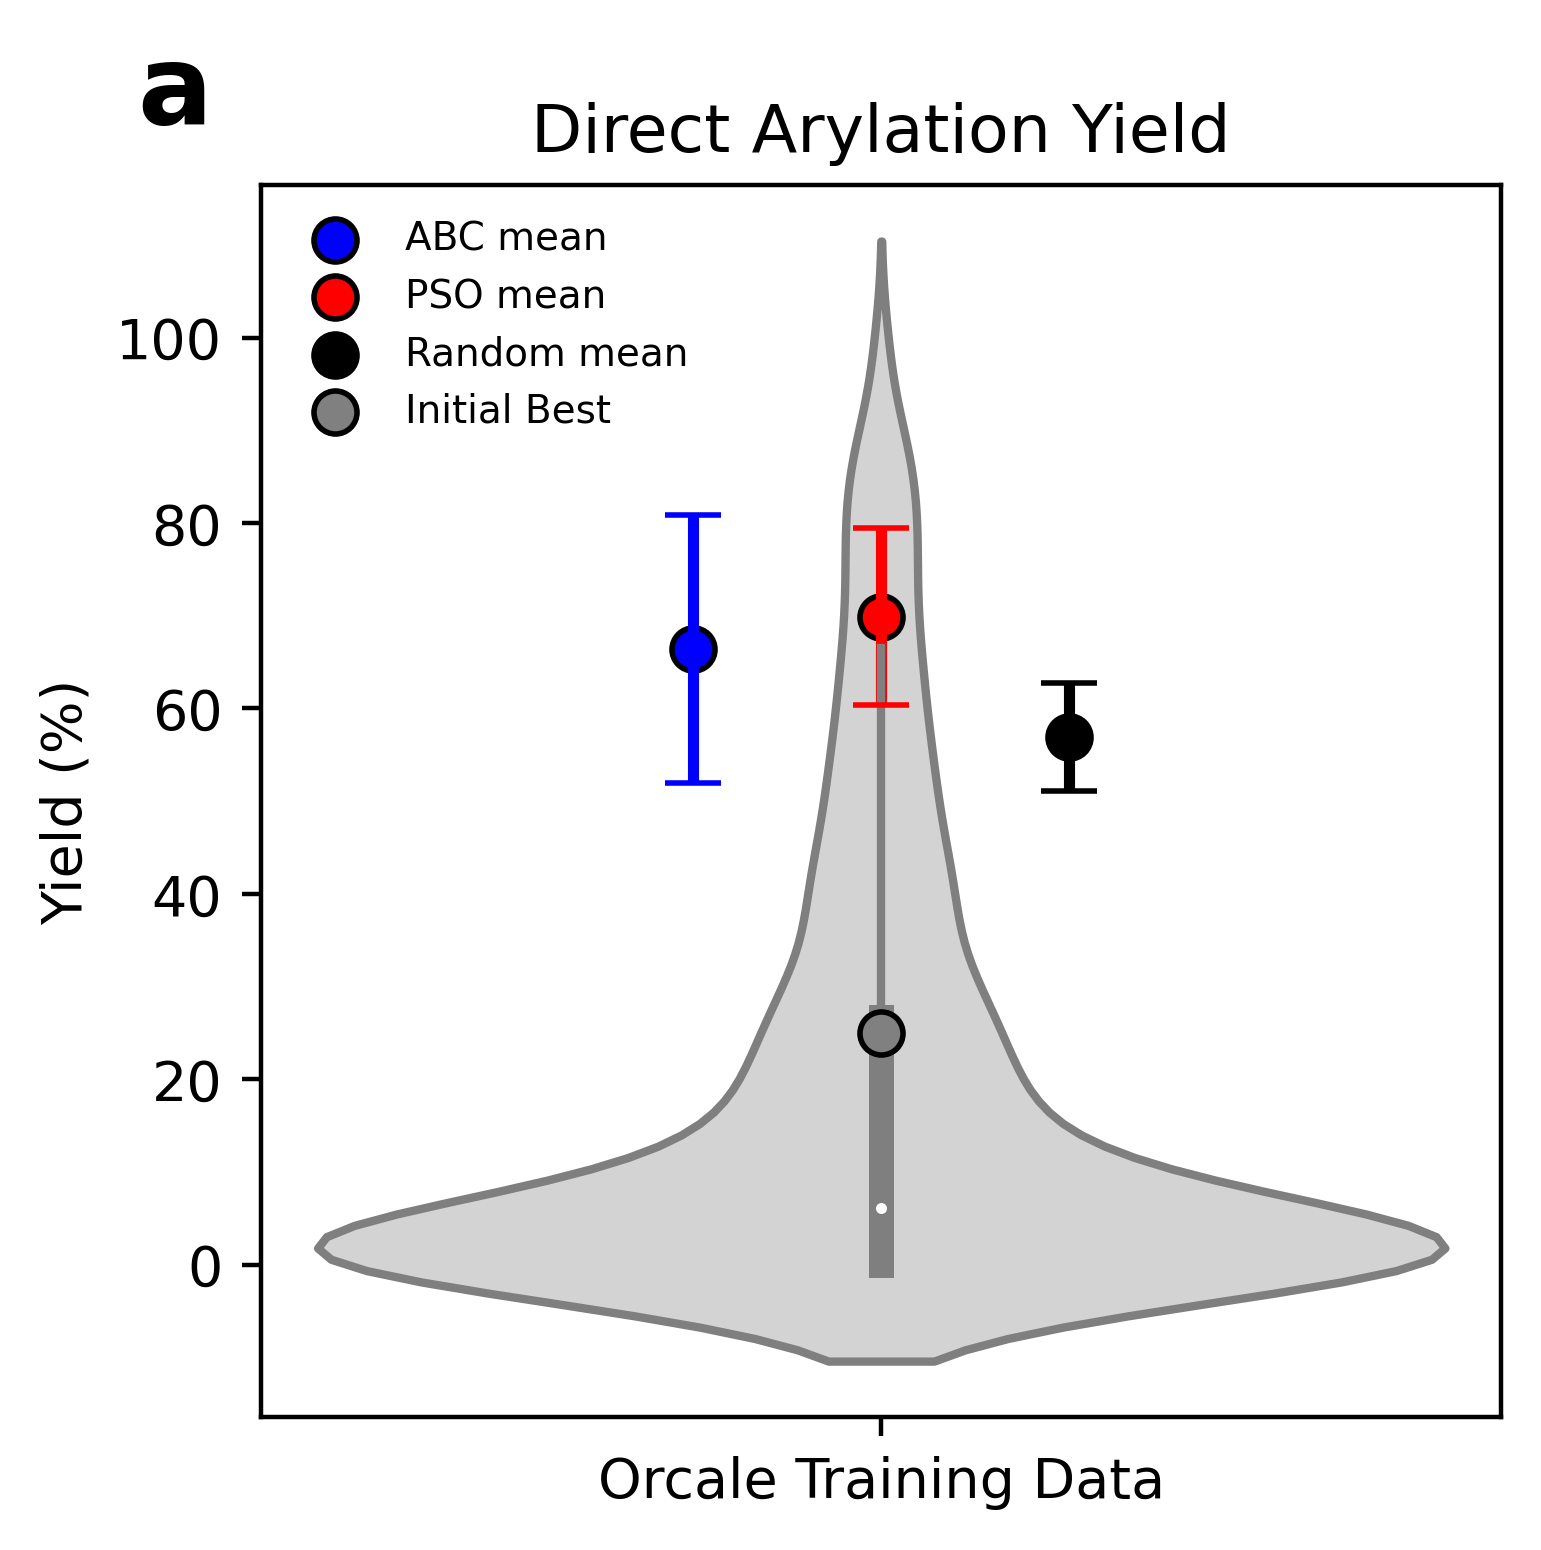

In [8]:
import numpy as np
from scipy.stats import sem  # 計算標準誤差（optional）
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ...前面資料讀取與計算保持不變...

plt.figure(figsize=(4,4), dpi=400)

# 小提琴圖
sns.violinplot(y=original_values, color='lightgray', width=0.3)

# 改成畫平均值與標準差誤差線
colors = {'ABC': 'blue', 'PSO': 'red', 'Random': 'black'}
for i, method in enumerate(methods):
    mean_val = best_solutions[method].mean()
    std_val = best_solutions[method].std()
    # 水平座標稍微偏移，避免重疊
    x = 0 + 0.05 * (i - 1)
    
    # 畫平均值點
    plt.scatter(x, mean_val, color=colors[method], s=60, edgecolor='black', label=f'{method} mean')
    # 畫誤差線 (± std)
    plt.errorbar(x, mean_val, yerr=std_val, fmt='none', ecolor=colors[method], elinewidth=2, capsize=5)

# 標出 initial best = 1.66
initial_best = 25
plt.scatter(
    0, initial_best,
    color='grey', s=60, edgecolor='black',
    label='Initial Best', zorder=5
)

plt.ylabel('Yield (%)')
plt.xticks([0], ['Orcale Training Data'])
plt.text(-0.1, 1.05, 'a', fontsize=20, fontweight='bold',
         transform=plt.gca().transAxes)  # 軸座標系
plt.title('Direct Arylation Yield')

plt.legend(frameon=False, loc='upper left', fontsize=7)
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/best_solutions_violin_plot.png', bbox_inches='tight')
plt.show()
